For this project, I stumbled across a tidytuesday data set that had per capita co2 emissions data for various food categories by country in 2013. The basis of each of my visualization originated from a question that I sought to answer through the visualization. In this file, each question is queried right before the code used to construct the visualization. 

In [1]:
library(tidyverse)
library(ggrepel)
library(ggthemes)
library(readxl)
library(ggsci)

#reading in data
food_consumption <- read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-02-18/food_consumption.csv')
global_emissions = read_excel('CO2_Emissions.xls', sheet = 1)
meta_data_global_emissions = read_excel('CO2_Emissions.xls', sheet = 2)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Parsed with column specification:
cols(
  country = col_character(),
  food_category = col_character(),
  consumption = col_double(),
  co2_emmission = col_double()
)



In [2]:
head(food_consumption)

country,food_category,consumption,co2_emmission
<chr>,<chr>,<dbl>,<dbl>
Argentina,Pork,10.51,37.20
Argentina,Poultry,38.66,41.53
Argentina,Beef,55.48,1712.00
Argentina,Lamb & Goat,1.56,54.63
Argentina,Fish,4.36,6.96
Argentina,Eggs,11.39,10.46


# Which countries have the greatest non-animal or animal per capita consumption?

In [3]:
animal_products = c('Pork', 'Poultry', 'Beef', 'Lamb & Goat','Fish','Milk - inc. cheese', 'Eggs')
non_animal_products = c('Wheat and Wheat Products', 'Rice','Soybeans','Nuts inc. Peanut Butter')

animal_product_sum = food_consumption %>%
    filter(food_category %in% animal_products) %>%
    group_by(country) %>% 
    summarize(animal_prod_country_sum = sum(consumption))

non_animal_product_sum = food_consumption %>%
    filter(food_category %in% non_animal_products) %>%
    group_by(country) %>% 
    summarize(non_animal_prod_country_sum = sum(consumption))

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



In [8]:
#getting ratio of animal to non-animal products
ratio = animal_product_sum$animal_prod_country_sum/non_animal_product_sum$non_animal_prod_country_sum
#adding country names to df
final_df = data.frame(cbind(non_animal_product_sum$country, ratio))
#assigning column names
colnames(final_df) = c('Country', 'Ratio')
#need to make proporition col a numeric
final_df$Ratio = as.numeric(final_df$Ratio)
#Want to change this df so that I can facet wrap by countries that eat greater proportion of animal or non-animal prod
final_df = final_df %>% 
    mutate(Greater_Animal_Category = ifelse(Ratio < 1, 'Non-Animal','Animal'))
#putting this new col into a factor to change it's position in the figure
final_df$Greater_Animal_Category = factor(final_df$Greater_Animal_Category, levels = c('Non-Animal','Animal'))

head(final_df)

,Country,Ratio,Greater_Animal_Category
,<chr>,<dbl>,<fct>
1,Albania,2.5331609,Animal
2,Algeria,0.9137397,Non-Animal
3,Angola,1.2469973,Animal
4,Argentina,2.8213936,Animal
5,Armenia,1.9862099,Animal
6,Australia,4.1442318,Animal


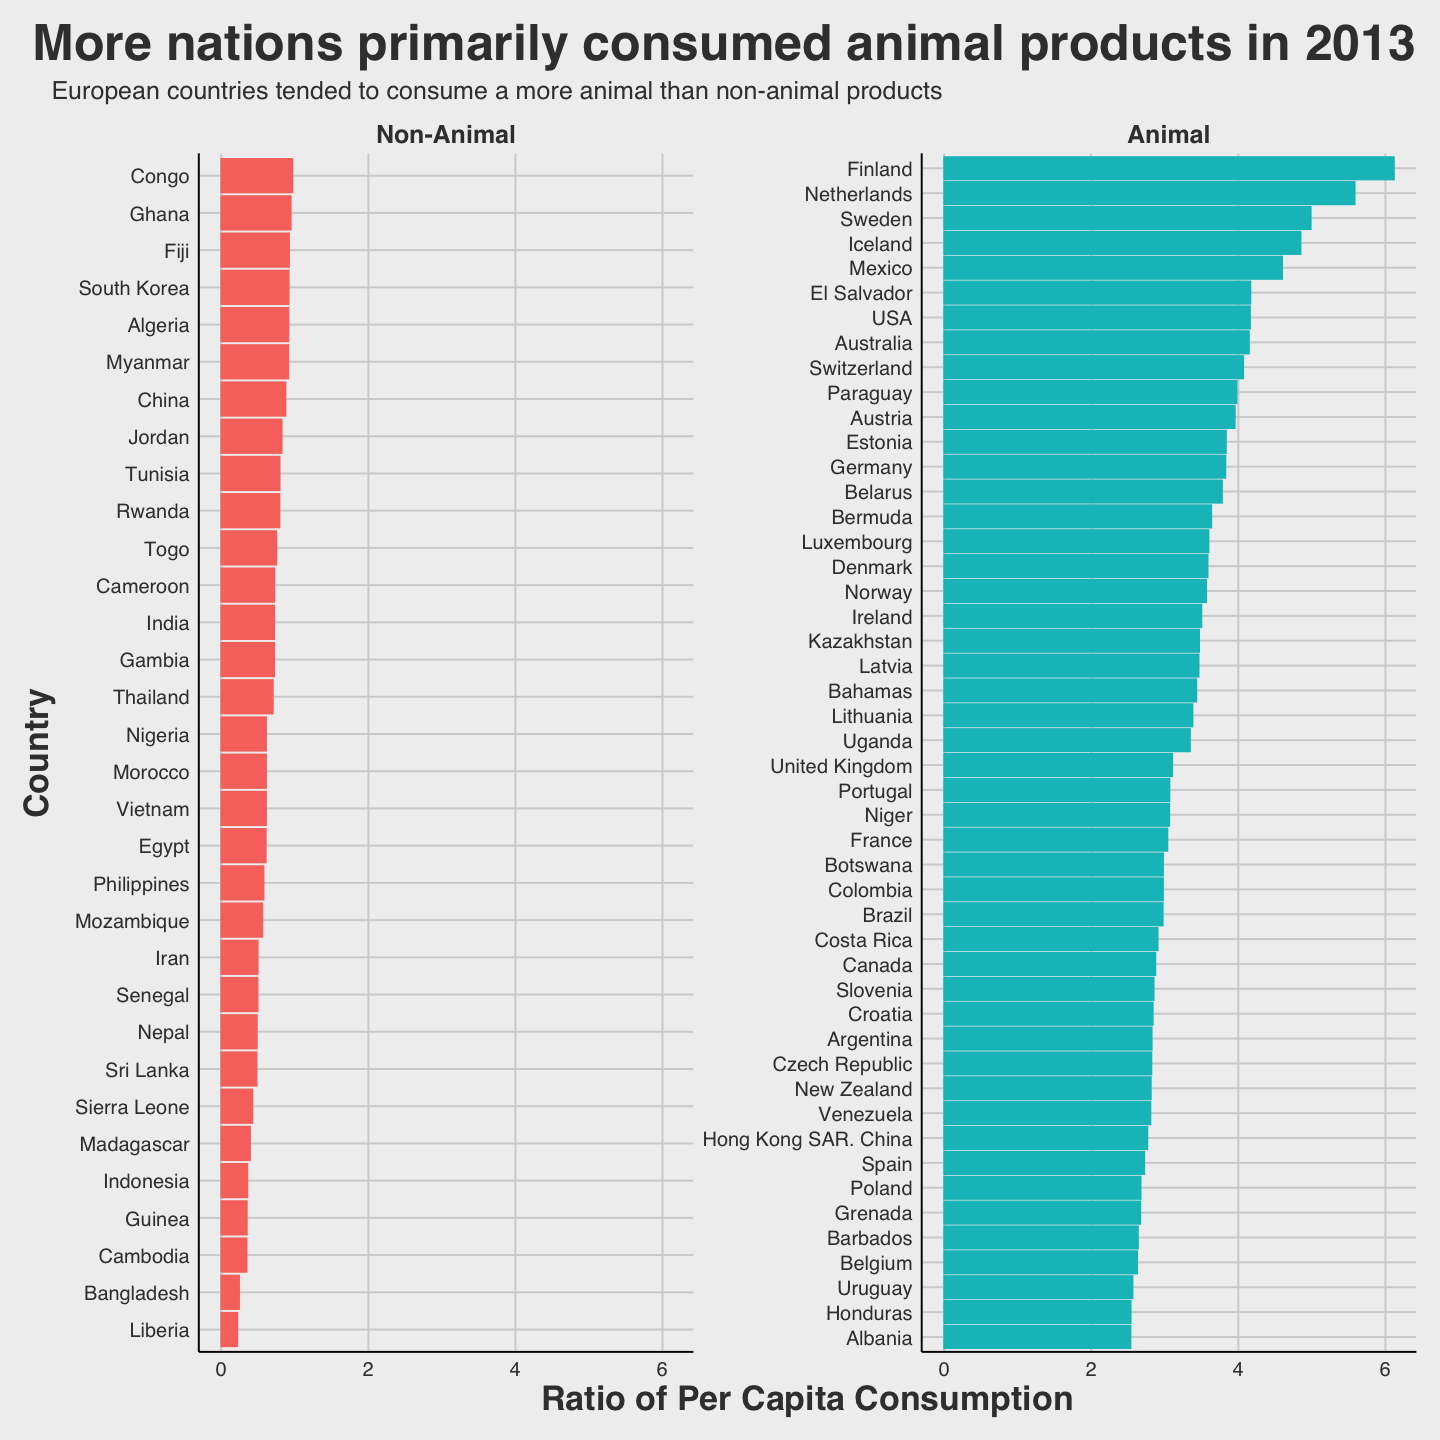

In [30]:
options(repr.plot.width = 12, repr.plot.height = 12)
ggplot(data = final_df %>%
      filter(Ratio < 1 | Ratio > 2.5)) + #removing countries just to make visualization nicer
  geom_col(aes(x = Ratio, y = reorder(Country, Ratio), color = Greater_Animal_Category, fill = Greater_Animal_Category)) + 
  facet_wrap(~Greater_Animal_Category, scales = 'free_y') +

  theme_fivethirtyeight() + 
  theme(axis.line = element_line(colour="black"), #making x and y axes black
        axis.text = element_text(size = 12), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        axis.title.y = element_text(margin = margin(r = 12)), #changing y axis title
        legend.position = "none", #removing legend
        legend.text = element_text(size = 12), #changes legend text
        strip.text.x = element_text(size = 15, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 15, face = "bold"),
        plot.title = element_text(hjust = 1, size = 30), #changing plot title
        plot.subtitle = element_text(hjust = -0.45, size = 15), #changing plot subtitle
        plot.margin = unit(c(0.5,0.5,0.5,0.5), "cm")) + #changes size of facet y axis 

   labs(title = 'More nations primarily consumed animal products in 2013', 
       subtitle = "European countries tended to consume a more animal than non-animal products",
        x = 'Ratio of Per Capita Consumption', y = ('Country')) 


This figure plots the ratio of per capita consumption by country. The ratio is a ratio of animal product consumption to non-animal product consumption per capita. Therefore, a ratio greater than 1 is indicative of consuming a greater proportion of animal products and a ratio less than 1 is indicative of consuming a smaller proportion of non-animal products. The visualization was stratified by countries that consumed more animal products, denoted as 'Animal', and countries that consumed more non-animal products, denoted as 'Non-Animal'to easily compare which countries fell into each category. 

This visualization reveals that more countries (from the data) tended to source a majority of their diets from animal products rather than non-animal products. (More countries were emmitted from the animal column to make the visualization less crowded). Questions that I had coming away from this data included, "What other regions and income levels are associated with countries that consume more animal vs. non-animal products?" along with the question below.

# Which animal product causes the greatest CO2 emissions?

In [32]:
mutated_food_consumption = food_consumption %>%
    group_by(food_category) %>%
    mutate(median_co2_emmissions = median(co2_emmission), Animal_Category = ifelse(food_category %in% animal_products, 'Animal', 'Non-Animal'))

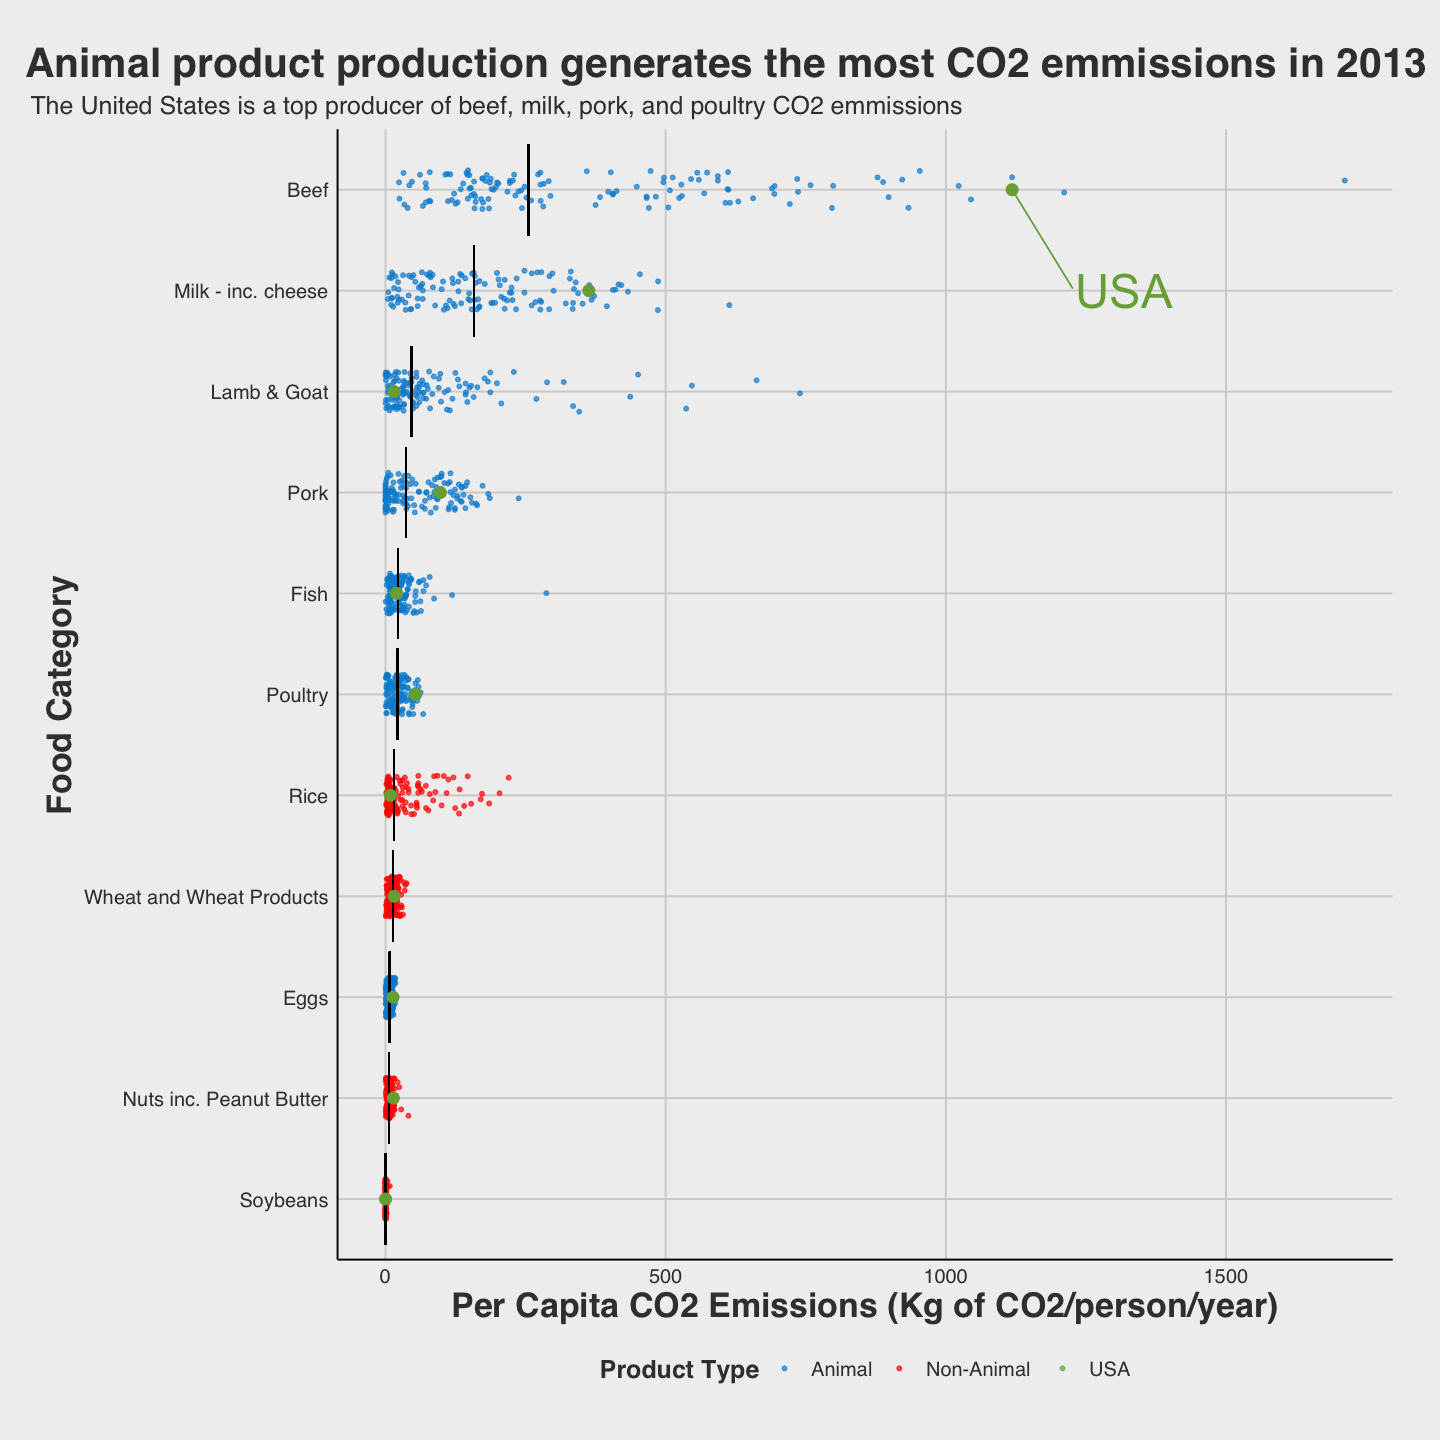

In [53]:
ggplot(data = mutated_food_consumption, aes(y = reorder(food_category, median_co2_emmissions), x = co2_emmission)) + 
  geom_point(aes(color = Animal_Category),
             position = position_jitter(h = 0.2, w = 0), alpha = 0.7, size = 1) +
  geom_crossbar(aes(x = median_co2_emmissions, y = food_category, xmin = median_co2_emmissions, 
                    xmax = median_co2_emmissions), size = 0.2) + 
  geom_point(data = mutated_food_consumption %>% 
             filter(country == 'USA'), show.legend = FALSE, aes(color = country), size = 3) + 
  geom_text_repel(data = mutated_food_consumption %>% 
                  filter(country == 'USA'& food_category == 'Beef'), #labeling a green point for USA
    nudge_x = 200,
    nudge_y = -1,
    segment.size = 0.5,
    size = 10, 
    show.legend = FALSE, 
    aes(label = country, color = country)) +

  theme_fivethirtyeight() + 

    theme(axis.line = element_line(colour="black"), #making x and y axes black
        axis.text = element_text(size = 12), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        legend.title = element_text(face="bold", size = 15),
        legend.text = element_text(size = 12), #changes legend text
        plot.margin = unit(c(1,1,1,1), "cm"),
        plot.title = element_text(hjust = 0.9, size = 24.5), #changing plot title
        plot.subtitle = element_text(hjust = -2.5, size = 15)) + #changing plot subtitle

  scale_color_fivethirtyeight() +

  labs(title = 'Animal product production generates the most CO2 emmissions in 2013',
       subtitle = "The United States is a top producer of beef, milk, pork, and poultry CO2 emmissions",
       x = "Per Capita CO2 Emissions (Kg of CO2/person/year)", y = 'Food Category', color = 'Product Type',
      label = 'United States')

This country plots the distribution of per capita CO2 emissions by food category. The graph was organized by median per capita CO2 emission represented by the black lines organized from highest to lowest. It is well known that the United States disproportionately produces more CO2 emissions than most countries, especially in regards to food production, so the US was highlighted in green. 

Overall, this visualization shows that animal products rank in the top 6 highest median per capita CO2 emissions. In addition, the United States consistently ranks higher in most of these categories including beef, milk, pork, poultry, eggs, and nuts. This made me wonder how these data changed over time, but I was unable to find data on CO2 emissions from food production over time. Therefore, my next figure shows overall CO2 emissions over time. 

# How have CO2 emissions changed over time and what events are associated with fluctuations in emissions?

In [54]:
#changing name of North Korea bc it was giving me issues 
for (i in 1:length(global_emissions$`Country Name`)){
    if(global_emissions$`Country Name`[i] == 'Korea, Dem. People’s Rep.'){
        global_emissions$`Country Name`[i] = 'North Korea'
    }
}

#making cols into factors
global_emissions$`Country Name` = factor(global_emissions$`Country Name`)
global_emissions$`Country Code` = factor(global_emissions$`Country Code`)

#pivoting data
global_emissions = global_emissions %>%
    pivot_longer(cols = `1960`:`2016`, values_drop_na = TRUE)

#changing col names
colnames(global_emissions) = c('Country Name','Country Code','Year', 'CO2 Emissions')
head(global_emissions)

Country Name,Country Code,Year,CO2 Emissions
<fct>,<fct>,<chr>,<dbl>
Aruba,ABW,1960,204.6204
Aruba,ABW,1961,208.8228
Aruba,ABW,1962,226.1181
Aruba,ABW,1963,214.8004
Aruba,ABW,1964,207.6158
Aruba,ABW,1965,185.2040


In [55]:
#joining the two global emissions dataframes
global_emissions_df = global_emissions %>%
    inner_join(meta_data_global_emissions) %>%
    select(`Country Name`, `Country Code`, Year, `CO2 Emissions`, Region, IncomeGroup)

#putting into a factor
global_emissions_df$IncomeGroup = factor(global_emissions_df$IncomeGroup, levels = c('Low income', 
                                                                                     'Lower middle income',
                                                                                    'Upper middle income',
                                                                                    'High income'))

head(global_emissions_df)

Joining, by = "Country Code"



Country Name,Country Code,Year,CO2 Emissions,Region,IncomeGroup
<fct>,<chr>,<chr>,<dbl>,<chr>,<fct>
Aruba,ABW,1960,204.6204,Latin America & Caribbean,High income
Aruba,ABW,1961,208.8228,Latin America & Caribbean,High income
Aruba,ABW,1962,226.1181,Latin America & Caribbean,High income
Aruba,ABW,1963,214.8004,Latin America & Caribbean,High income
Aruba,ABW,1964,207.6158,Latin America & Caribbean,High income
Aruba,ABW,1965,185.2040,Latin America & Caribbean,High income


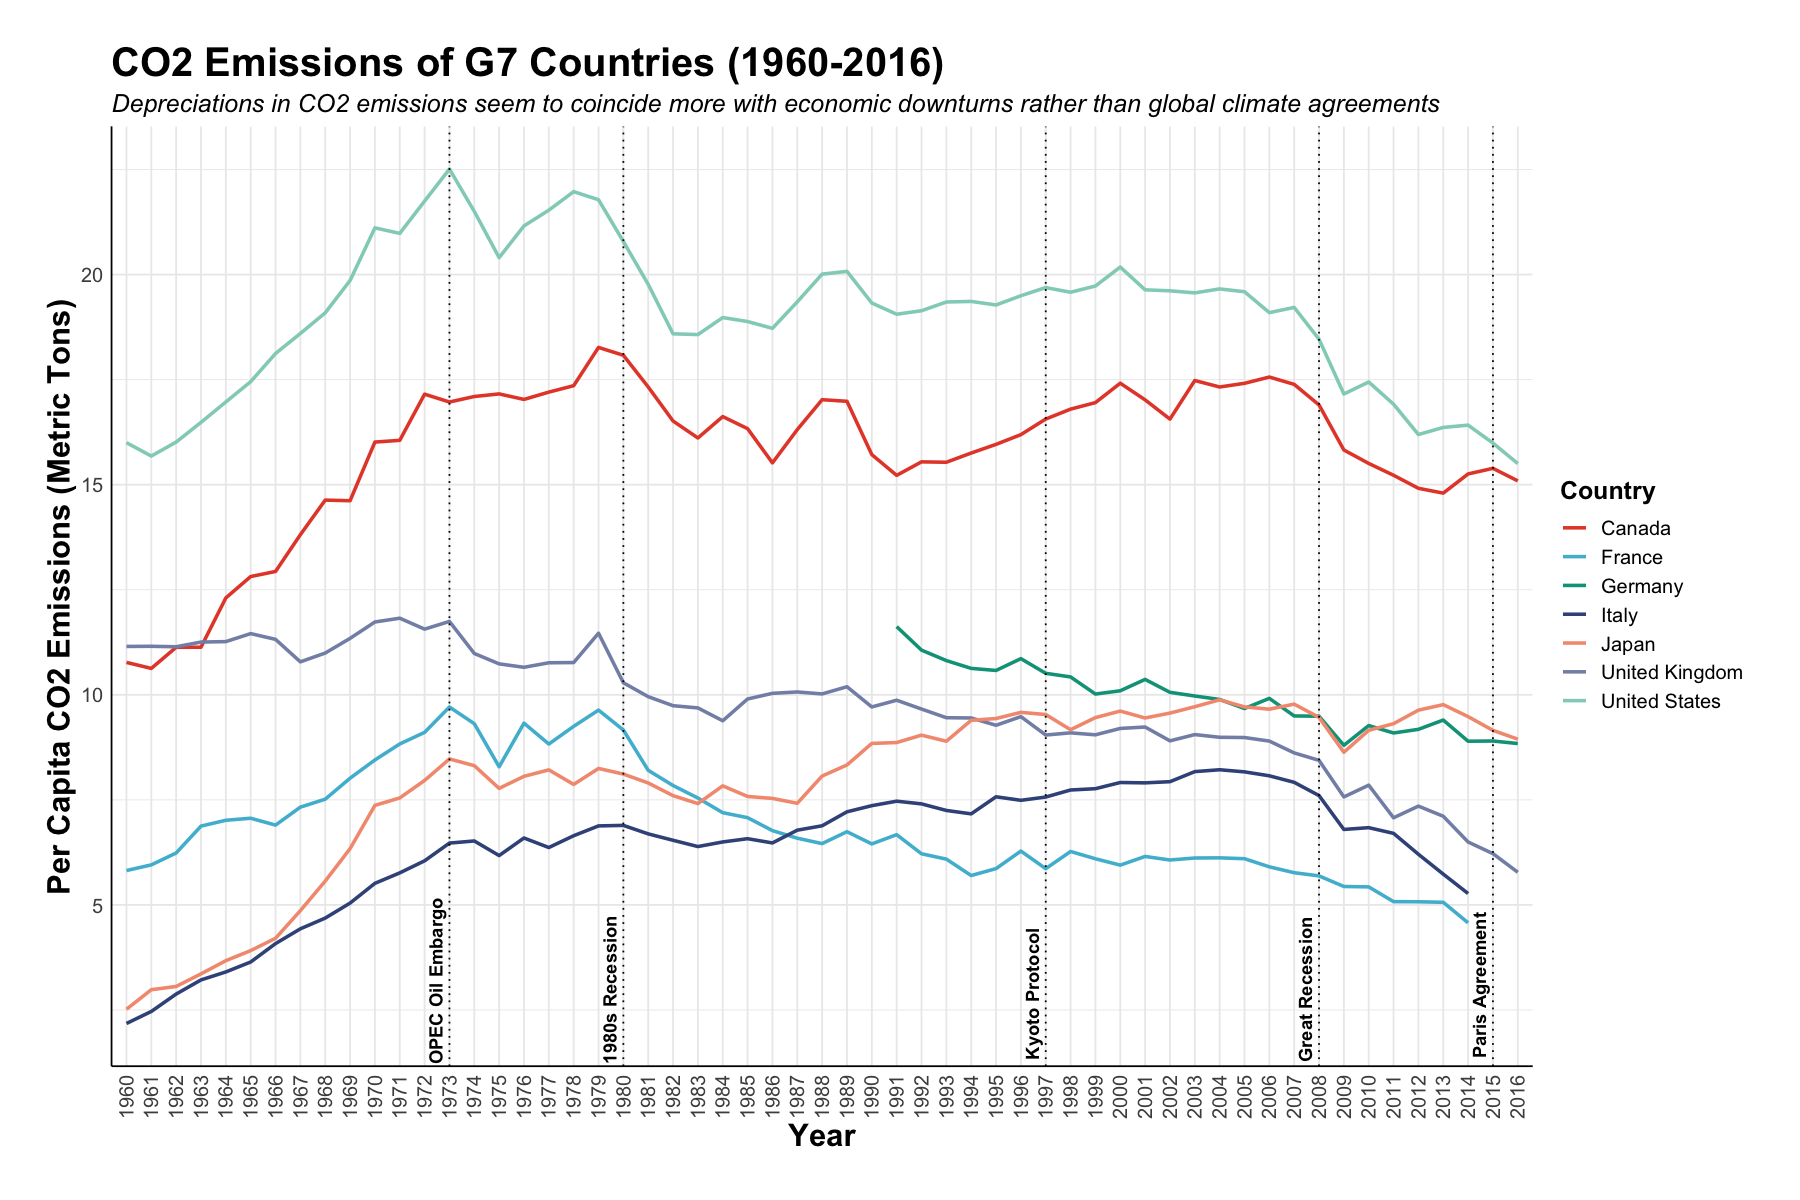

In [56]:
#G7 countries
G7_countries = c("Japan", "United States", "France", "Germany", "Italy", "Canada", "United Kingdom")

options(repr.plot.width = 15, repr.plot.height = 10)
ggplot() + 
  geom_line(data = global_emissions_df %>%
      filter(`Country Name` %in% G7_countries), aes(x = Year, y = `CO2 Emissions`, group = `Country Code`, 
                                                    color = `Country Name`), size = 1) + 
  geom_vline(xintercept = "1973", linetype = "dotted") + # OPEC oil embargo
  geom_text(aes(x = "1973", label = "OPEC Oil Embargo\n", y = 3.2), angle = 90, fontface = "bold") +
  geom_vline(xintercept = "1980", linetype = "dotted") + # Stagflation --> recession beginning in 1980
  geom_text(aes(x = "1980", label = "1980s Recession\n", y = 3), angle = 90, fontface = "bold") +
  geom_vline(xintercept = "1997", linetype = "dotted") + #Kyoto protocol (first legally binding treaty)
  geom_text(aes(x = "1997", label = "Kyoto Protocol\n", y = 2.9), angle = 90, fontface = "bold") +
  geom_vline(xintercept = "2008", linetype = "dotted") + #stock market crash --> Great Recession
  geom_text(aes(x = "2008", label = "Great Recession\n", y = 3), angle = 90, fontface = "bold") +
  geom_vline(xintercept = "2015", linetype = "dotted") + #Paris agreement
  geom_text(aes(x = "2015", label = "Paris Agreement\n", y = 3.1), angle = 90, fontface = "bold") +

  theme_minimal() + 
  scale_color_npg() + 

  theme(axis.line = element_line(colour="black"), #making x and y axes black
        axis.text = element_text(size = 12), #changing size of x axis labels
        axis.text.x = element_text(angle = 90, vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        legend.title = element_text(face= "bold", size = 15),
        legend.text = element_text(size = 12), #changes legend text
        plot.margin = unit(c(1,1,1,1), "cm"),
        plot.title = element_text(size = 24, face = "bold"), #changing plot title
        plot.subtitle = element_text(size = 15, face = "italic")) + #changing plot subtitle

  labs(title = 'CO2 Emissions of G7 Countries (1960-2016)',
       subtitle = "Depreciations in CO2 emissions seem to coincide more with economic downturns rather than global climate agreements",
       y = 'Per Capita CO2 Emissions (Metric Tons)', color = 'Country')

The figure above displays per capita CO2 emissions of G7 countries by year. The G7 countries were chosen to view a smaller subset of the initial data set. In addition, these countries play significant roles in global leadership including addressing climate change, so I was interested in seeing if their country's CO2 emissions decreased after signing a global climate agreement. 

The United States has the highest per capita emissions, but they have been steadily decreasing to reach 1960's levels in 2016. Germany and the United Kingdom are the only two countries that have consistently trended downwards. It's important to note that correlation isn't synonymous with causation, so while many of the economic downturns coincided with decreases in CO2 emissions it's not possible to tell from this graph if the economic downturns were the cause of decreasing CO2 emissions. One limitation of this figure includes the fact that the Paris agreement was signed in 2015 and the data ends in 2016, so it's not possible to see long term trends after the Paris agreement. Another limitation includes the fact that this figure doesnt' include an exhaustive list of all global climate agreements and recessions. 